# Auto Encoder Implementation

## Setup and prepare datas

In [1]:
import noise
import torch 
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from torch.utils.tensorboard import SummaryWriter

In [2]:
# Initialized device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [3]:
# hyperparams
bs=128
step=0
lr=3e-4
num_epochs=30
latent_space=10
criterion=torch.nn.MSELoss()
#writer_tensorboard = SummaryWriter(f"runs/noise")
#writer_tensorboard_denoised = SummaryWriter(f"runs/denoised")

In [4]:
# load dataset
dset = torchvision.datasets.MNIST(
    root="../gan 2014/data/",
    train=True,
    download=True
)

# info 
dset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../gan 2014/data/
    Split: Train

torch.Size([28, 28])


/opt/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


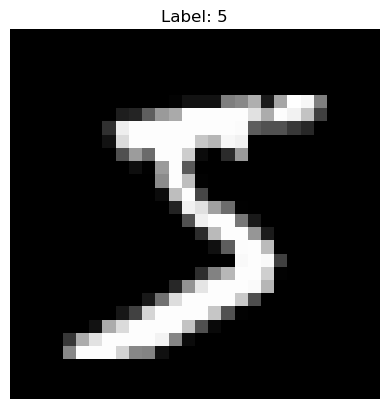

In [5]:
# Plot images
print(dset.train_data[0].shape)
plt.title(f"Label: {dset.train_labels[0]}")
plt.axis('off')
plt.imshow(dset.train_data[0], cmap='gray')
plt.show()

In [6]:
dset_train, y_train = dset.train_data, dset.train_labels # train
dset_test, y_test = dset.test_data, dset.test_labels # test 

/opt/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Add Noise

**Pour les bruits je me suis inspire des bruits utilises dans la capsule fidle pour AE et VAE à savoir :**
- bruit gaussien
- poivre et sel
- bruit loi de poisson
- bruit speckler

In [7]:
noise_image=noise.add_noise(dset_train)# train noise
noise_test=noise.add_noise(dset_test) # test noise

60000it [00:09, 6336.98it/s]


Noise adding sucessfully.


60000it [00:09, 6478.84it/s]

Noise adding sucessfully.


noise_shape: (28, 28)


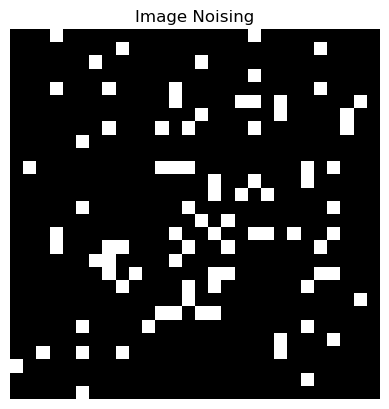

In [8]:
plt.title("Image Noising")
plt.axis('off')
print(f"noise_shape: {noise_image[0].shape}")
plt.imshow(noise_image[0], cmap='gray')
plt.show()

0it [00:00, ?it/s]

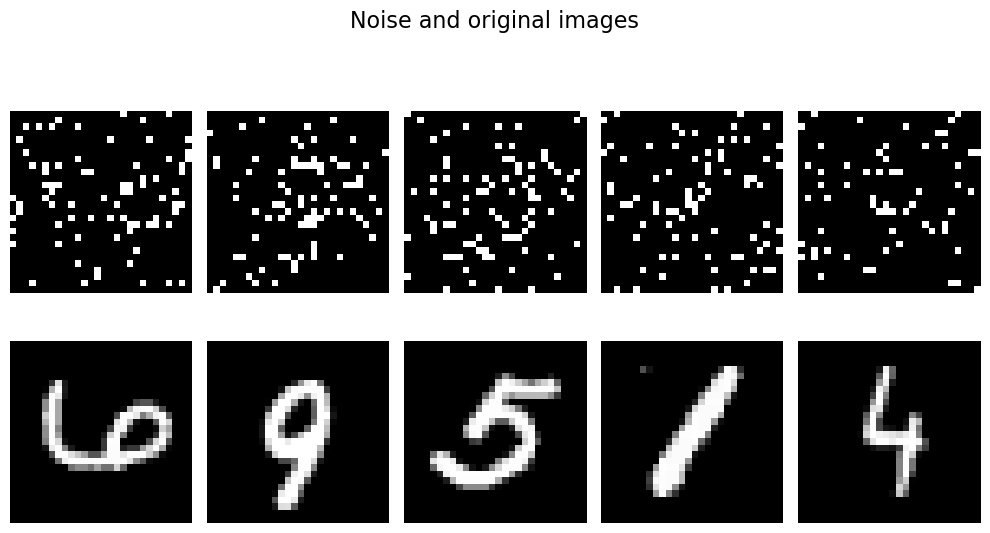

In [9]:
indices = np.random.choice(len(dset_train), 5, replace=False)
fig, axes = plt.subplots(2,5,figsize=(10,6))
fig.suptitle("Noise and original images", fontsize=16)
plt.subplots_adjust(hspace=0.1)


for i, idx in tqdm(enumerate(indices)):
    axes[0,i].imshow(noise_image[idx], cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(dset_train[idx], cmap='gray')
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
class Data(torch.utils.data.Dataset):
    """
    Custom dataset
    """
    def __init__(self, data, noise, targets):
        self.data=data
        self.noise=noise
        self.targets=targets
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, ids):
        return (
        torch.tensor(self.data[ids] / 255.0, dtype=torch.float32).unsqueeze(0), 
        torch.tensor(self.noise[ids] / 255.0, dtype=torch.float32).unsqueeze(0),
        )

In [11]:
dset_loader = Data(dset_train, noise_image, y_train) 
dset_loader = torch.utils.data.DataLoader(dset_loader, batch_size=bs, shuffle=True)

dset_test_loader = Data(dset_test, noise_test, y_test)
dset_test_loader=torch.utils.data.DataLoader(dset_test_loader, batch_size=bs, shuffle=True)

## Model

In [12]:
class DenoisingAutoencoder(torch.nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), 
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )

        # Latent Space
        self.latent_space = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64 * 7 * 7, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64 * 7 * 7),
            torch.nn.ReLU(),
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Unflatten(1, (64, 7, 7)),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 7, 7) -> (32, 14, 14)
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 14, 14) -> (1, 28, 28)
            torch.nn.Sigmoid(),  # Output pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent_space(x)
        x = self.decoder(x)
        return x

In [13]:
ae_denoised = DenoisingAutoencoder().to(device)
opt = torch.optim.Adam(ae_denoised.parameters(), lr=3e-4)
ae_denoised

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (latent_space): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=3136, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2

In [14]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    ae_denoised.train()
    train_losses = []
    test_losses=[]
    epoch_loss = 0
    for clean_imgs, noisy_imgs in dset_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = ae_denoised(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(dset_loader))
    
    ae_denoised.eval()
    test_loss = 0
    
    with torch.no_grad():
        for clean_imgs, noisy_imgs in dset_test_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = ae_denoised(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            test_loss += loss.item()
    test_losses.append(test_loss / len(dset_test_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')  

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/2k/078ng9w935bc_wvxlwg1z_rm0000gn/T/ipykernel_52220/1555178825.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.data[ids] / 255.0, dtype=torch.float32).unsqueeze(0),


Epoch 1/30, Train Loss: 0.0809, Test Loss: 0.0640
Epoch 2/30, Train Loss: 0.0572, Test Loss: 0.0575
Epoch 3/30, Train Loss: 0.0543, Test Loss: 0.0554
Epoch 4/30, Train Loss: 0.0521, Test Loss: 0.0616
Epoch 5/30, Train Loss: 0.0501, Test Loss: 0.0874
Epoch 6/30, Train Loss: 0.0489, Test Loss: 0.0548
Epoch 7/30, Train Loss: 0.0468, Test Loss: 0.0523
Epoch 8/30, Train Loss: 0.0424, Test Loss: 0.1214
Epoch 9/30, Train Loss: 0.0401, Test Loss: 0.0538
Epoch 10/30, Train Loss: 0.0384, Test Loss: 0.0583
Epoch 11/30, Train Loss: 0.0312, Test Loss: 0.0475
Epoch 12/30, Train Loss: 0.0287, Test Loss: 0.0601
Epoch 13/30, Train Loss: 0.0274, Test Loss: 0.0530
Epoch 14/30, Train Loss: 0.0263, Test Loss: 0.0513
Epoch 15/30, Train Loss: 0.0252, Test Loss: 0.0526
Epoch 16/30, Train Loss: 0.0242, Test Loss: 0.0522
Epoch 17/30, Train Loss: 0.0234, Test Loss: 0.0525
Epoch 18/30, Train Loss: 0.0226, Test Loss: 0.0548
Epoch 19/30, Train Loss: 0.0218, Test Loss: 0.0640
Epoch 20/30, Train Loss: 0.0211, Test Lo

## Evaluation

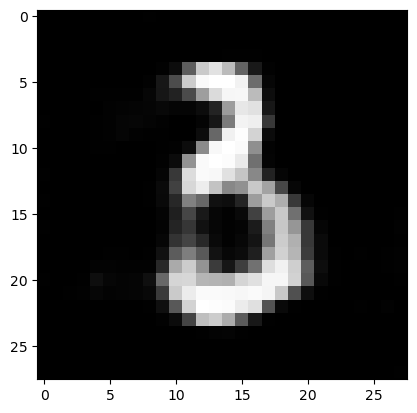

In [15]:
# check fast denoising on train set 
z = outputs[5].detach().cpu().numpy()
plt.imshow(z[0], cmap='gray')
plt.show()

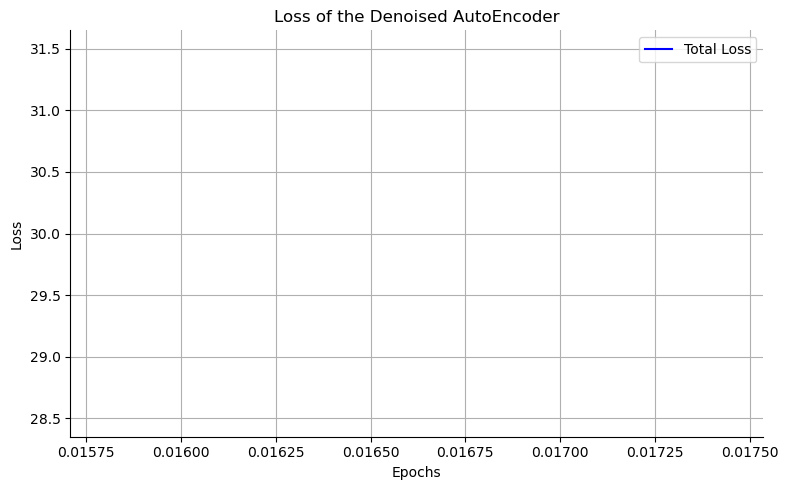

In [19]:
plt.figure(figsize=(8, 5))
plt.title("Loss of the Denoised AutoEncoder")
plt.plot(train_losses, num_epochs,  label='Total Loss', color='blue')

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.legend(loc='upper right')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
ae_denoised.eval()
with torch.no_grad():
    eval=ae_denoised(dset_test.to(device))
#indices = np.random.choice(len(dset_test), 5, replace=False)
fig, axes = plt.subplots(3,5,figsize=(10,6))
fig.suptitle("Noise, predicted and original images", fontsize=16)
plt.subplots_adjust(hspace=0.1)


for i, idx in tqdm(enumerate(indices)):
    eval_img=eval[idx].detach().cpu().numpy()
    axes[0,i].imshow(noise_test[idx], cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(eval_img.squeeze(0), cmap='gray')
    axes[1,i].axis('off')
    axes[2,i].imshow(dset_test[idx], cmap='gray')
    axes[2,i].axis('off')

plt.tight_layout()
plt.show()

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

(1, 28, 28)


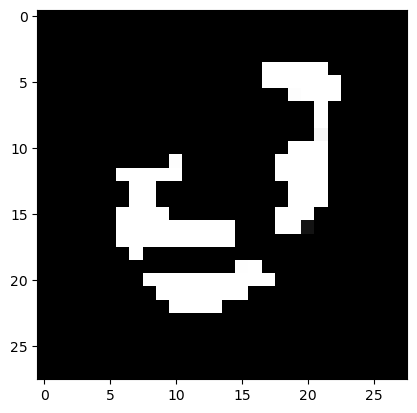

In [ ]:
e=ae_denoised(dset_test.to(device))
e=e[0].detach().cpu().numpy()
print(e.shape)
plt.imshow(e.squeeze(0), cmap='gray')

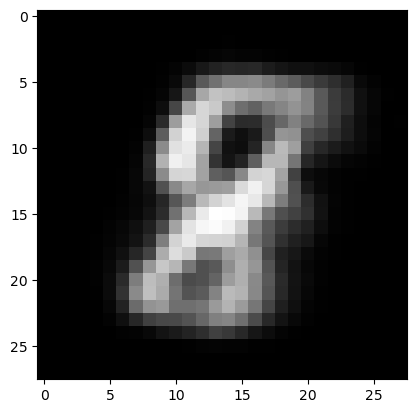

In [ ]:
z = outputs[5].detach().cpu().numpy()
plt.imshow(z[0], cmap='gray')
plt.show()